In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

In [3]:
path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
data_path = 'data/'

# Full datasets

In [4]:
# Amazon
df_am = pd.read_pickle(path + data_path + 'Amazon/Amazon_full')
# subsets
names_am = ['Amazon_05_users', 'Amazon_01_users', 'Amazon_005_users', 'Amazon_001_users']

# MovieLens
df_ml = pd.read_pickle(path + data_path + 'ML/ML_full')
# subsets
names_ml = ['ML_05_users', 'ML_01_users', 'ML_005_users', 'ML_001_users']

# Splits
- 0.5 * total users
- 0.1 * total users
- 0.05 * total users
- 0.01 * total users

In [5]:
splits = [0.5, 0.1, 0.05, 0.01]

## Leave users out

In [6]:
def leave_users_out(full_data, leave_out):
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user_id')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [7]:
def data_split(df, splits, names, store_path):
    total_users = len(df.user.unique())

    for i, split in enumerate(splits):
        n_users = int(split * total_users)
        print('File:', names[i], ' #Users:', n_users)
        leftovers, new_df = leave_users_out(df, n_users)
        new_df.to_pickle(store_path + names[i])

In [8]:
df_am['item_id'] = df_am.item.astype('category').cat.codes
df_am['user_id'] = df_am.user.astype('category').cat.codes

In [9]:
df_ml['item_id'] = df_ml.item.astype('category').cat.codes
df_ml['user_id'] = df_ml.user.astype('category').cat.codes

## Splits Amazon

In [85]:
store_path = path + data_path + 'Amazon/'
data_split(df_am, splits, names_am, store_path)

File: Amazon_05_users Users: 606864
File: Amazon_01_users Users: 121372
File: Amazon_005_users Users: 60686
File: Amazon_001_users Users: 12137


## Splits MovieLens

In [89]:
store_path = path + data_path + 'ML/'
data_split(df_ml, splits, names_ml, store_path)

File: ML_05_users  #Users: 81270
File: ML_01_users  #Users: 16254
File: ML_005_users  #Users: 8127
File: ML_001_users  #Users: 1625


# Time Sorting Per User

In [10]:
def time_sort_user(names, data_path):
    for name in names:
        from progressbar import ProgressBar
        pbar = ProgressBar()
        df = pd.read_pickle(data_path + name)
        users = df.user.unique()
        new_df = pd.DataFrame(columns=list(df))
        for u in pbar(users):
            df_u = df[df['user']==u]
            df_u = df_u.sort_values(by='datetime')
            new_df = pd.concat([new_df, df_u])
        new_df.to_pickle(data_path + name)    

In [15]:
path + data_path + 'Amazon/' + names_am[0]

'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/data/Amazon/Amazon_05_users'

In [ ]:
# Amazon
file_path = path + data_path + 'Amazon/'
time_sort_user([names_am[0]], file_path)

In [42]:
names_ml[:3]

['ML_05_users', 'ML_01_users', 'ML_005_users']

In [ ]:
# MovieLens
file_path = path + data_path + 'ML/'
time_sort_user(names_ml[:3], file_path)

# Exploration

In [11]:
df['user_rating_counts'] = df.groupby('user')['rating'].transform('count')
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

rows  105644 
#ratings 105644 
#ratings/user 8.7 
#ratings/item 1.71 
average rating 4.28 
#users  12137 
#items  61616 
sparse  0.99986 %


FileNotFoundError: [Errno 2] No such file or directory: 'Plots/Deliverables/rating_dist_ml.png'

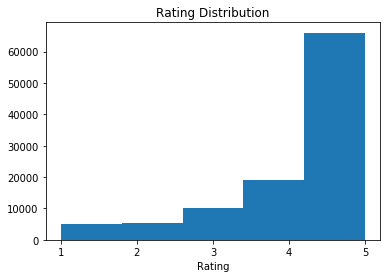

In [13]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')

df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 100)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 100)
plt.xlim([0,30])
plt.title('#ratings per user distribution (1000 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

# Other Splits

## Leave item out

In [ ]:
def leave_x_out(full_data, leave_out):
    # Input: data must be formatted by func: tranfsorm
    # Output: full_data = without all entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    index_to_drop = []
    
    for indices in user_items_ind:
        if len(indices) > leave_out:
            for to_leave_out in range(leave_out):
                index = indices[- to_leave_out]
                index_to_drop.append(index)
    
    leave_one_out_set = full_data.loc[index_to_drop]
    full_data_leave_one_out = full_data.drop(index_to_drop)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_one_out_set.drop(columns=['index'])

---
## Setting rating threshold of 3 and above for a 1

In [ ]:
# user_thres = 5

In [ ]:
# df['#ratings'] = df.groupby('user')['user'].transform('count')
# df = df[df['#ratings'] >= user_thres].drop(columns=['#ratings'])

In [30]:
df_upper = df[df['user_rating_counts'] > median].copy()
df_lower = df[df['user_rating_counts'] <= median].copy()

In [33]:
df_lower = df_lower.drop(columns=['user_rating_counts'])

In [51]:
df

,user,item,datetime,rating,user_rating_counts
0,A2IC3NZN488KWK,0871167042,2014-05-04,5.0,16
1,A30FG02C424EJ5,0871167042,2014-03-31,5.0,6
2,A2G9GWQEWWNQUB,0871167042,2015-05-30,5.0,10
3,A3NI5OGW35SLY2,0871167042,2015-02-21,5.0,5
4,A1OPRA4NE56EV6,0871167042,2015-01-21,5.0,7
...,...,...,...,...,...
11285454,A2ENZHR6N5WV6S,B01HJHR8A6,2017-03-27,4.0,20
11285455,ALOIB506XZBQP,B01HJHR8A6,2017-02-06,2.0,5
11285456,A25IAJ2112FA09,B01HJHR8A6,2016-12-30,5.0,16
11285457,A2ZFPAT7GQ77D9,B01HJHC4WS,2016-11-23,5.0,5


In [35]:
pd.read_pickle(path + data_path + 'Amazon_lo_all_users_4m')

,user,item,datetime,rating
1,A30FG02C424EJ5,0871167042,2014-03-31,5.0
3,A3NI5OGW35SLY2,0871167042,2015-02-21,5.0
4,A1OPRA4NE56EV6,0871167042,2015-01-21,5.0
7,A1YIEW86G14BHP,0871167042,2014-07-23,3.0
10,AZI75OKBKZ98R,0871167042,2014-05-10,5.0
...,...,...,...,...
11285448,A4U6BHSB96BFD,B01HJH7W0W,2017-02-14,5.0
11285449,A23BKWHWCZXTF6,B01HJH7W0W,2017-01-31,4.0
11285450,A2AGN73TX9LB3V,B01HJHR8A6,2018-05-31,2.0
11285455,ALOIB506XZBQP,B01HJHR8A6,2017-02-06,2.0


In [19]:
renames = {'datetime':'date'}
df = df.rename(renames)

In [27]:
df = df[['user', 'item', 'datetime', 'rating']]
df.to_pickle(path + data_path + 'Amazon_10m')

In [52]:
df_lower.to_pickle(path + data_path + 'Amazon/Amazon_lo_all_users_4m')
df_upper.to_pickle(path + data_path + 'Amazon/Amazon_up_all_users_6_5m')

In [60]:
df = df_og

In [9]:
df['datetime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df = df.drop(columns=['unixReviewTime'])

In [30]:
df = df.drop(columns=['user_rating_counts'])

In [13]:
df = df[df['verified']==True]

In [32]:
df = df.drop(columns=['verified'])

In [66]:
df = df_upper

In [53]:
df.to_pickle(path + data_path + 'Amazon/Amazon_10m')

In [29]:
median = user_ratings.median()
median

7.0

In [28]:
df['user_rating_counts'] = df.groupby('user')['rating'].transform('count')
user_ratings = df.groupby('user')['rating'].count()
item_ratings = df.groupby('item')['rating'].count()
norpu = user_ratings.mean()
norpi = item_ratings.mean()
total_users = df.user.unique().size
total_items = df.item.unique().size
sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))

rows  10592657 
#ratings 10592657 
#ratings/user 8.73 
#ratings/item 28.22 
average rating 4.28 
#users  1213729 
#items  375397 
sparse  0.99998 %


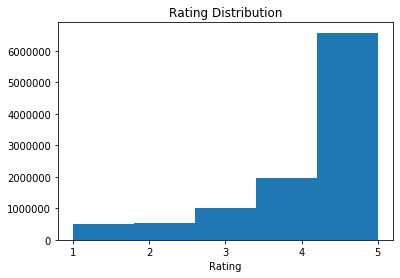

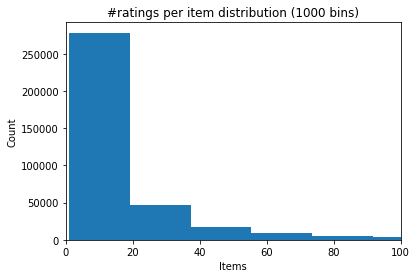

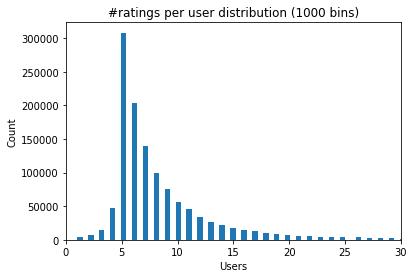

In [15]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size, '\nsparse ', round(sparseness,5), '%')

df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.xticks(range(1,6))
plt.savefig('Plots/Deliverables/rating_dist_ml')
plt.show()

plt.hist(item_ratings, bins = 1000)
plt.xlim([0,100])
plt.title('#ratings per item distribution (1000 bins)')
plt.xlabel('Items')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_item_dist_ml')
plt.show()

plt.hist(user_ratings, bins = 1000)
plt.xlim([0,30])
plt.title('#ratings per user distribution (1000 bins)')
plt.xlabel('Users')
plt.ylabel('Count')
plt.savefig('Plots/Deliverables/#ratings_per_user_dist_ml')
plt.show()

# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [36]:
df_lower['item_id'] = df_lower.item.astype('category').cat.codes
df_lower['user_id'] = df_lower.user.astype('category').cat.codes

## Leave item out train test split

In [37]:
def leave_x_out(full_data, leave_out):
    # Input: data must be formatted by func: tranfsorm
    # Output: full_data = without all entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    index_to_drop = []
    
    for indices in user_items_ind:
        if len(indices) > leave_out:
            for to_leave_out in range(leave_out):
                index = indices[- to_leave_out]
                index_to_drop.append(index)
    
    leave_one_out_set = full_data.loc[index_to_drop]
    full_data_leave_one_out = full_data.drop(index_to_drop)
    
    return full_data_leave_one_out.drop(columns=['index']), leave_one_out_set.drop(columns=['index'])

In [ ]:
def create_matrices(data, n_users, n_items):
        r = data['user_id']
        c = data['item_id']
        d = data['rating']
        m = sparse.csr_matrix((d, (r, c)), shape=(n_users, n_items))
        m_ones = m.copy()
        m_ones[m_ones > 0] = 1
                               
        return m, m_ones

In [ ]:
train_set, test_set = leave_x_out(df_new_ids, 2)
val_set, test_set = leave_x_out(test_set, 1)

## Leave users out 

In [38]:
def leave_users_out(full_data, leave_out):
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user_id')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [39]:
half_users = int(len(df_lower.user.unique())/2)
quarter_users = int(half_users/2)

In [40]:
quarter_users

181382

In [41]:
leftovers, lower_half_users = leave_users_out(df_lower, half_users)

In [42]:
leftovers, lower_quarter_users = leave_users_out(df_lower, quarter_users)

In [43]:
lower_quarter_users

,user,item,datetime,rating,item_id,user_id
339543,A4VZDM06BRTN8,B000EX15NY,2017-07-18,5.0,3708,559648
1002052,A4VZDM06BRTN8,B0017LT9OO,2017-07-18,5.0,14774,559648
1002901,A4VZDM06BRTN8,B0017LT9PS,2017-07-18,5.0,14775,559648
1320045,A4VZDM06BRTN8,B0017LT9OO,2017-07-18,5.0,14774,559648
1320894,A4VZDM06BRTN8,B0017LT9PS,2017-07-18,5.0,14775,559648
...,...,...,...,...,...,...
4324769,ADTNVGWWY99H2,B00CDJX87S,2014-04-28,5.0,118967,607152
4438633,ADTNVGWWY99H2,B00CZ7L3HA,2014-04-28,3.0,124374,607152
6204989,ADTNVGWWY99H2,B00MGG0YK2,2016-02-20,5.0,205931,607152
9945462,ADTNVGWWY99H2,B007RKKM04,2016-03-03,5.0,80068,607152


In [44]:
len(lower_quarter_users.user_id.unique())

181382

In [48]:
lower_half_users.to_pickle(path + data_path + 'Amazon/Amazon_lo_half_users')

In [49]:
lower_quarter_users.to_pickle(path + data_path + 'Amazon/Amazon_lo_quarter_users')

In [47]:
df_upper['item_id'] = df_upper.item.astype('category').cat.codes
df_upper['user_id'] = df_upper.user.astype('category').cat.codes

half_users = int(len(df_upper.user.unique())/2)
quarter_users = int(half_users/2)

quarter_users

leftovers, upper_half_users = leave_users_out(df_upper, half_users)

leftovers, upper_quarter_users = leave_users_out(df_upper, quarter_users)

upper_quarter_users

len(upper_quarter_users.user_id.unique())



In [50]:
upper_half_users.to_pickle(path + data_path + 'Amazon/Amazon_up_half_users')

upper_quarter_users.to_pickle(path + data_path + 'Amazon/Amazon_up_quarter_users')